In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys ; sys.path.append("../..")
import json
import shap
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm.auto import tqdm
from torchvision import models, transforms
from mpl_toolkits.axes_grid1 import ImageGrid

from data.util.cocofake import get_cocofake

# Load Model

In [13]:
COCO_PATH = "/u00/data/coco-2014"
COCOFAKE_PATH = "/u00/data/cocofake"
# MODEL_PATH = "artifacts/best_mobilenetv2_interpolated.pt"
MODEL_PATH = "artifacts/best_mobilenetv2_scratch.pt"

In [14]:
DEVICE = "cuda:0"
model = torch.load(MODEL_PATH).to(DEVICE)
model.eval()

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Load Data

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = lambda x: transforms.Normalize(
    mean=mean, std=std
)(transforms.CenterCrop(512)(transforms.Resize(512)(x))).permute(1,2,0)

# transform = lambda x: transforms.Normalize(
#     mean=mean,
#     std=std,
# )(transforms.CenterCrop(512)(x))

train_data, val_data, test_data, = get_cocofake(
    COCO_PATH,
    COCOFAKE_PATH,
    train_limit=10000,
    val_limit=2500,
    real_transform=transform,
    fake_transform=transform,
    batch_size=4,
    train_n_workers=8,
    val_n_workers=2,
    num_fake=1
)

# Utilities

In [5]:
def normalize_image(img):
    return torch.clamp((img - torch.min(img)) / torch.max(img), min=0, max=1)

def plot_images(batch, model=None, **kwargs):
    batch_size = batch["real"].shape[0]
    n = min(batch_size, 4)
    fig, axes = plt.subplots(
        len(batch["fake"]) + 1, n, figsize=kwargs.pop("figsize", (12, 8))
    )
    
    real_imgs = batch["real"][:n]
    if model is not None:
        outputs = model(real_imgs.to(DEVICE))
        _, preds = torch.max(outputs, 1)
    for i, img in enumerate(real_imgs):
        if model is not None:
            title = f"real\npred: {'real' if preds[i] == 0 else 'fake'}"
        else:
            title = "real"
        axes[0][i].imshow(normalize_image(img.permute([1, 2, 0])))
        axes[0][i].set_title(title)
    
    for i, fake_imgs in enumerate(batch["fake"], 1):
        fake_imgs = fake_imgs[:n]
        if model is not None:
            outputs = model(fake_imgs.to(DEVICE))
            _, preds = torch.max(outputs, 1)
        for j, img in enumerate(fake_imgs):
            if model is not None:
                title = f"fake\npred: {'real' if preds[i] == 0 else 'fake'}"
            else:
                title = "fake"
            axes[i][j].imshow(normalize_image(img.permute([1, 2, 0])))
            axes[i][j].set_title(title)

# Sample Visualization

In [53]:
it = iter(test_data)

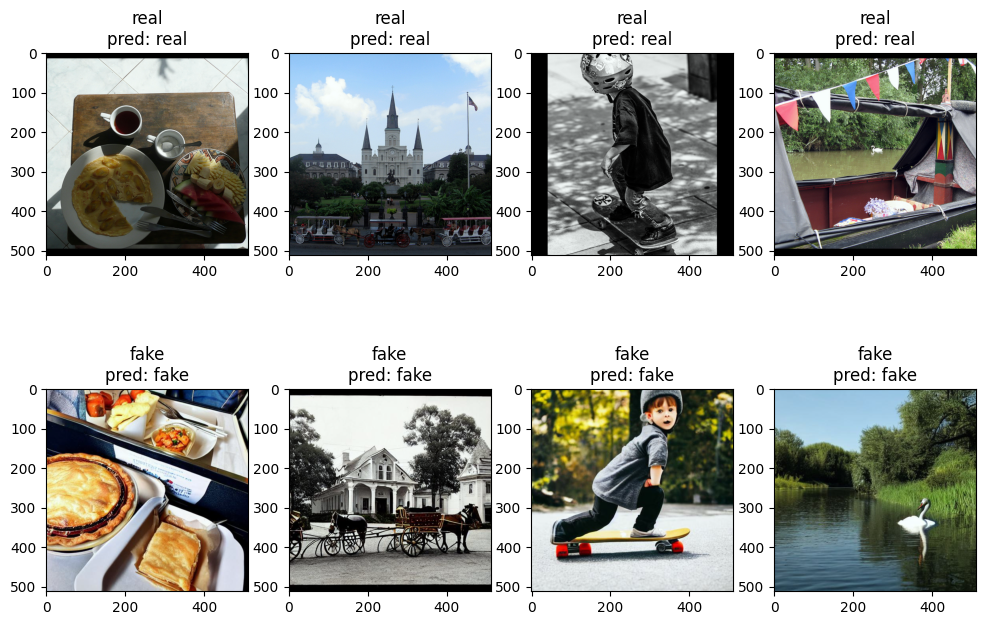

In [54]:
plot_images(next(it), model=model)

# Learning Curves

Note that the loss and accuracy values were copied manually from training output because the CSV file of the metrics did not save properly.

(0.0, 1.0)

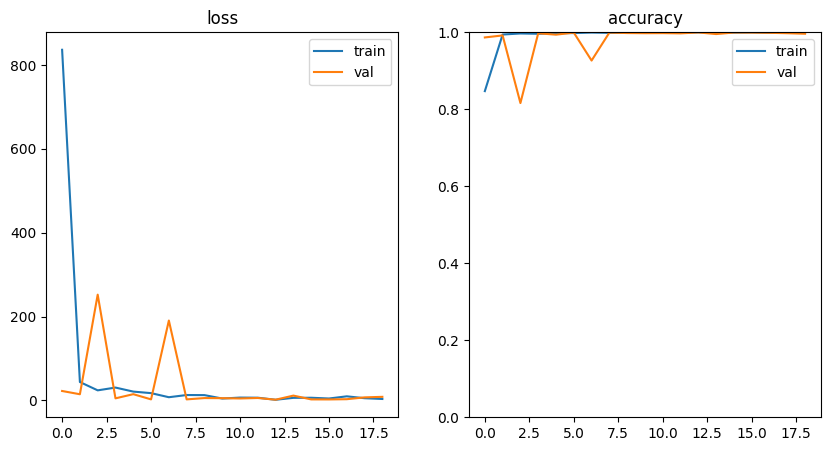

In [16]:
df = pd.read_csv(MODEL_PATH.replace(".pt", "_learning.csv"))
train_loss = df["train_loss"]
val_loss = df["val_loss"]
train_acc = df["train_acc"]
val_acc = df["val_acc"]

n = len(train_loss)
x = [*range(n)]
fix, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(x, train_loss, label="train")
axes[0].plot(x, val_loss, label="val")
axes[0].set_title("loss")
axes[0].legend()

axes[1].plot(x, train_acc, label="train")
axes[1].plot(x, val_acc, label="val")
axes[1].set_title("accuracy")
axes[1].legend()
axes[1].set_ylim(0,1)

# SHAP Explainations

In [6]:
def predict(img):
    if not isinstance(img, torch.Tensor):
        img = torch.tensor(img)
    img = img.permute(0,3,1,2)
    outputs = model(img.to(DEVICE))
    return outputs

In [7]:
topk = 2
batch_size = 4
n_evals = 10000

masker_blur = shap.maskers.Image("blur(16,16)", [512, 512, 3])

explainer = shap.Explainer(predict, masker_blur, output_names=["Real", "Fake"])

In [9]:
def explain(explainer, batch, gt):
    predictions = model(batch.permute(0,3,1,2))
    predictions = torch.argmax(predictions, 1)
    predictions = np.array([["real", "fake"] if x == 0 else ["fake", "real"] for x in predictions])
    
    shap_values = explainer(
        batch,
        max_evals=n_evals,
        batch_size=batch_size,
        outputs=shap.Explanation.argsort.flip[:topk],
    )
    
    data = shap_values.data.cpu().numpy()
    data = np.array(
        [normalize_image(torch.tensor(x)).cpu().numpy() for x in data]
    )
    values = ([val for val in np.moveaxis(shap_values.values, -1, 0)])

    shap.image_plot(
        shap_values=values,
        pixel_values=data,
    #     labels=shap_values.output_names,
#         labels=np.array([["Real", "Fake"],["Real", "Fake"],["Real", "Fake"],["Real", "Fake"]]),
        labels=predictions,
        true_labels=gt,
    )

In [10]:
it = iter(test_data)

  0%|          | 0/9998 [00:00<?, ?it/s]


PartitionExplainer explainer:  25%|██████████████████████                                                                  | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]


PartitionExplainer explainer:  75%|████████████████████████████████████████████████████████████                    | 3/4 [04:12<01:01, 61.63s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]


PartitionExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [06:14<00:00, 86.74s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]


PartitionExplainer explainer: 5it [08:17, 124.37s/it]                                                                                            


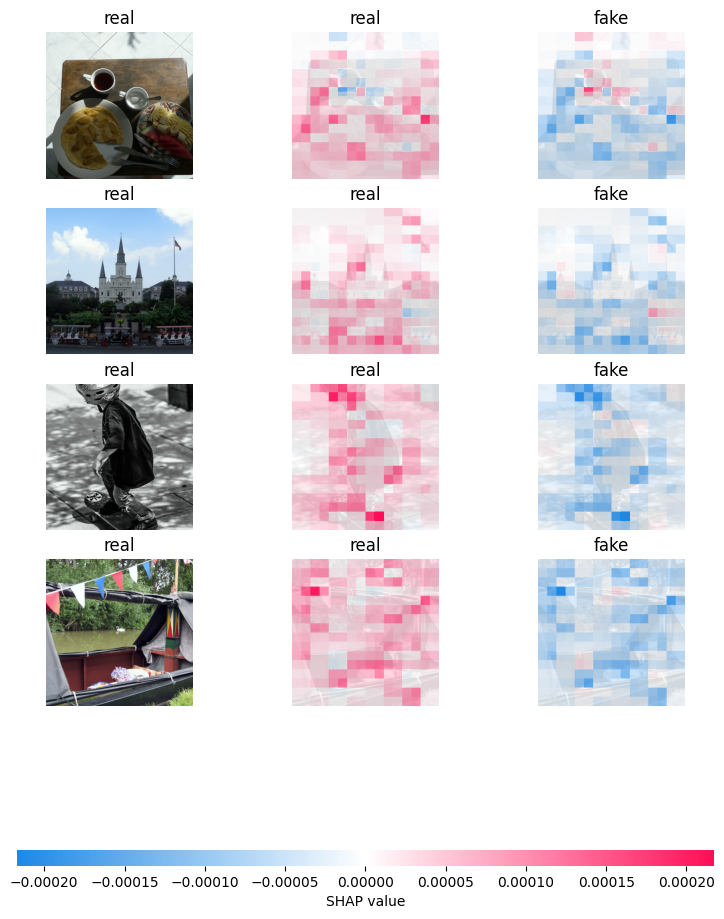

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██████████████████████                                                                  | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|████████████████████████████████████████████████████████████                    | 3/4 [04:06<01:01, 61.30s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [06:10<00:00, 87.16s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [08:14, 123.54s/it]                                                                                            


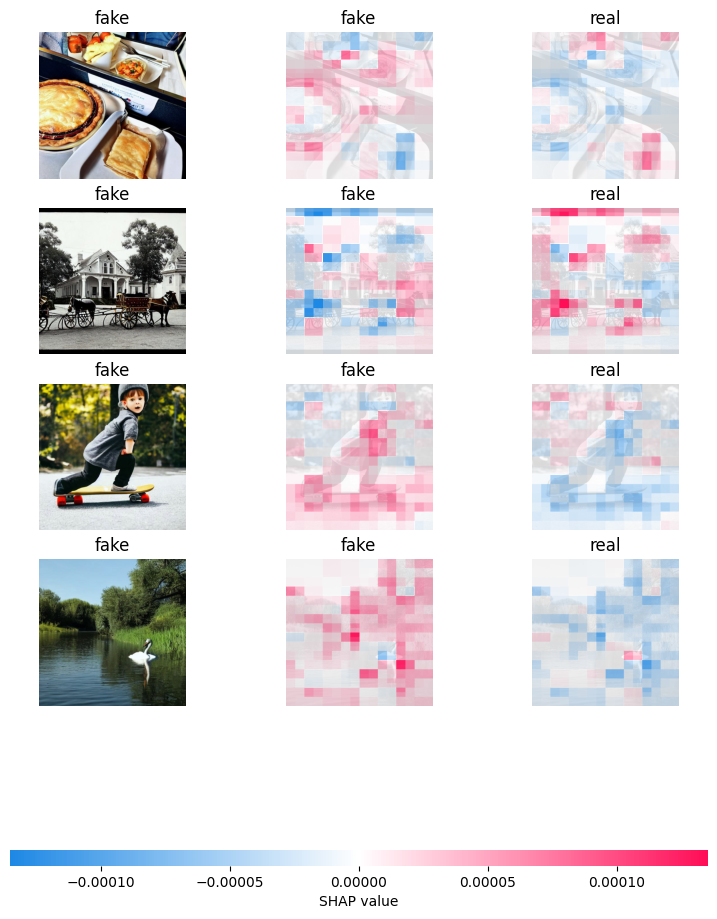

In [47]:
batch = next(it)
real = batch["real"].to(DEVICE)
explain(explainer, real, ["real"] * real.shape[0])

fake = batch["fake"][0].to(DEVICE)
explain(explainer, fake, ["fake"] * fake.shape[0])

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██████████████████████                                                                  | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|████████████████████████████████████████████████████████████                    | 3/4 [04:04<01:00, 60.95s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [06:06<00:00, 86.64s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [08:10, 122.51s/it]                                                                                            


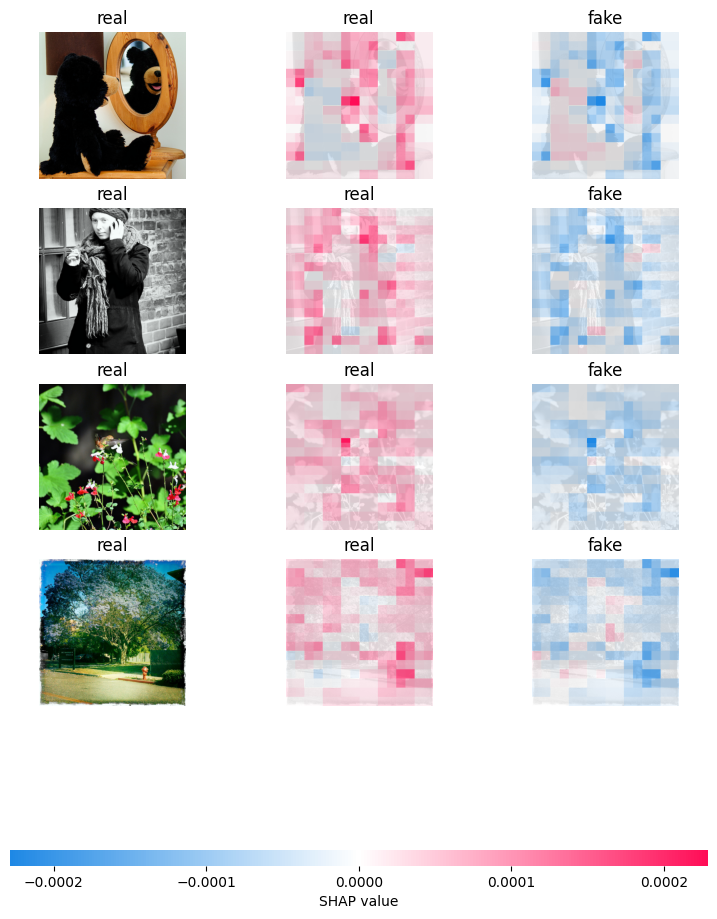

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██████████████████████                                                                  | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|████████████████████████████████████████████████████████████                    | 3/4 [04:06<01:01, 61.25s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [06:10<00:00, 87.56s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [08:14, 123.62s/it]                                                                                            


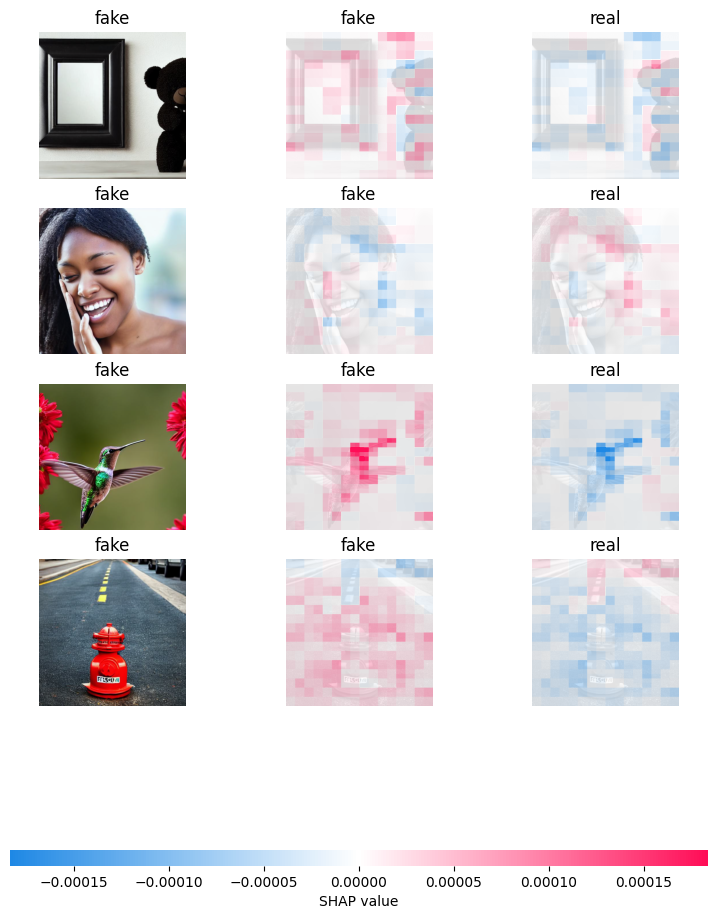

In [48]:
batch = next(it)
real = batch["real"].to(DEVICE)
explain(explainer, real, ["real"] * real.shape[0])

fake = batch["fake"][0].to(DEVICE)
explain(explainer, fake, ["fake"] * fake.shape[0])

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██████████████████████                                                                  | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|████████████████████████████████████████████████████████████                    | 3/4 [04:09<01:02, 62.05s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [06:13<00:00, 87.94s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [08:18, 124.55s/it]                                                                                            


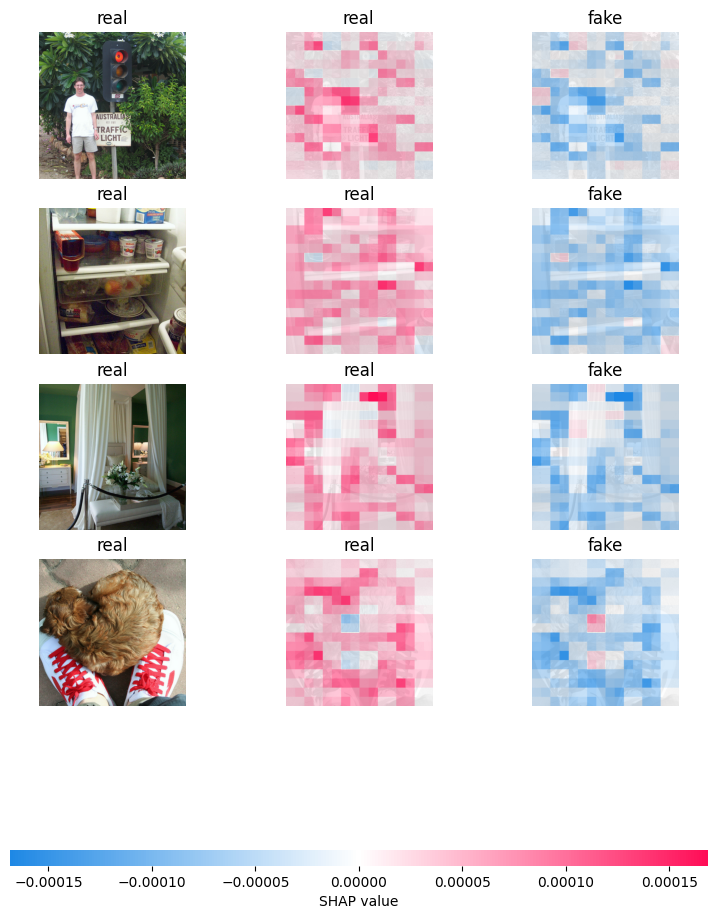

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██████████████████████                                                                  | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|████████████████████████████████████████████████████████████                    | 3/4 [04:08<01:02, 62.22s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [06:13<00:00, 88.41s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [08:18, 124.68s/it]                                                                                            


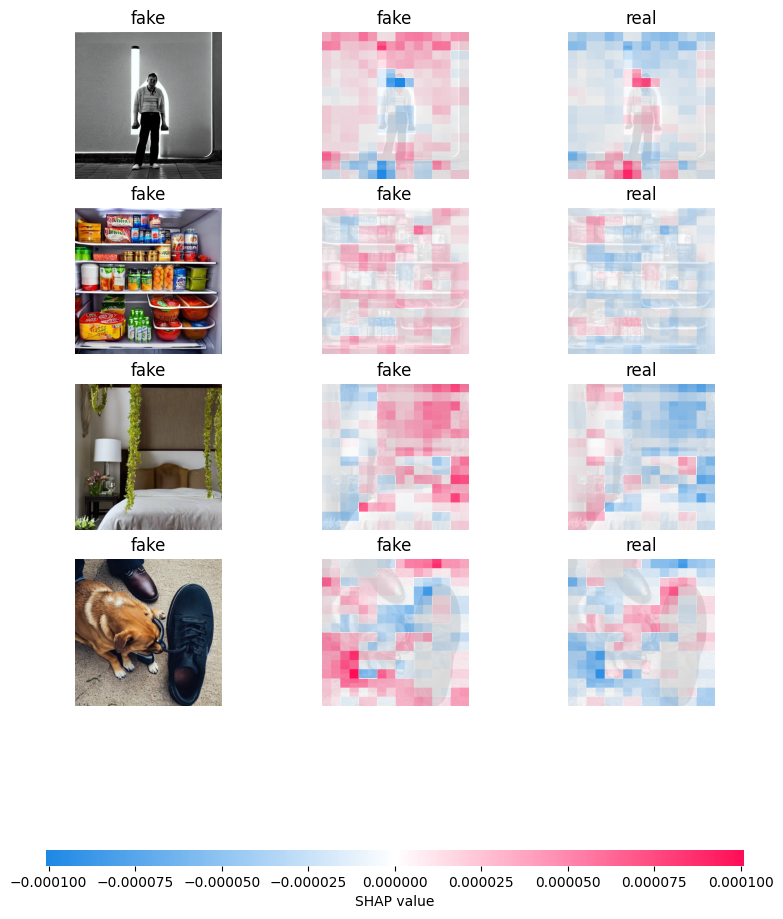

In [51]:
batch = next(it)
real = batch["real"].to(DEVICE)
explain(explainer, real, ["real"] * real.shape[0])

fake = batch["fake"][0].to(DEVICE)
explain(explainer, fake, ["fake"] * fake.shape[0])

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██████████████████████                                                                  | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|████████████████████████████████████████████████████████████                    | 3/4 [04:17<01:02, 62.34s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [06:21<00:00, 88.09s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [08:25, 126.41s/it]                                                                                            


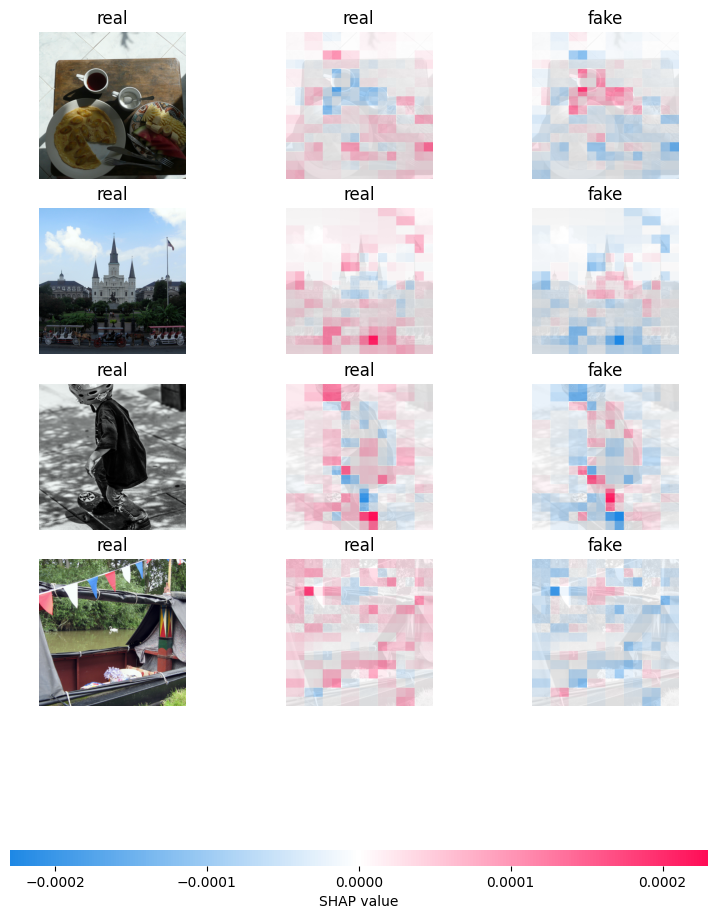

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██████████████████████                                                                  | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|████████████████████████████████████████████████████████████                    | 3/4 [04:10<01:02, 62.13s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [06:14<00:00, 87.93s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [08:18, 124.72s/it]                                                                                            


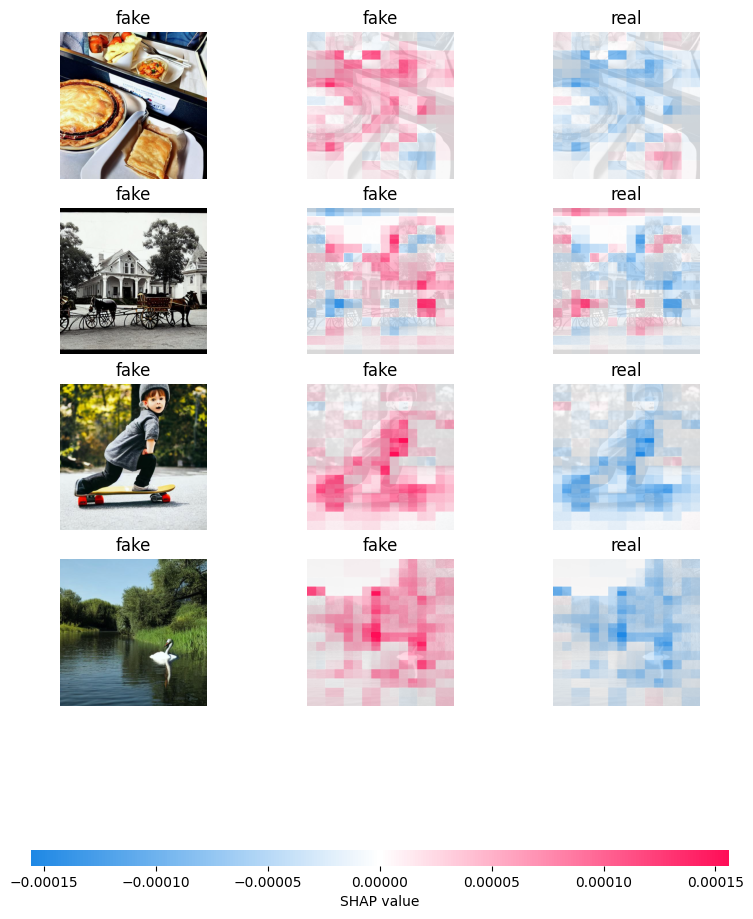

In [11]:
batch = next(it)
real = batch["real"].to(DEVICE)
explain(explainer, real, ["real"] * real.shape[0])

fake = batch["fake"][0].to(DEVICE)
explain(explainer, fake, ["fake"] * fake.shape[0])

[autoreload of torchvision.models.mobilenetv2 failed: Traceback (most recent call last):
  File "/home/IRDR/leemd1/environments/aiml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/IRDR/leemd1/environments/aiml/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 848, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/IRDR/leemd1/environments/aiml/lib/python3.8/site-packages/torchvision/models/mobilenetv2.py", line 228, in <module>
    def mobilenet_v2(
  File "/home/IRDR/leemd1/environments/aiml/lib/python3.8/site-packages/torchvision/models/_api.py", line 200,

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██████████████████████                                                                  | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|████████████████████████████████████████████████████████████                    | 3/4 [04:03<01:00, 60.77s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [06:06<00:00, 86.63s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [08:09, 122.30s/it]                                                                                            


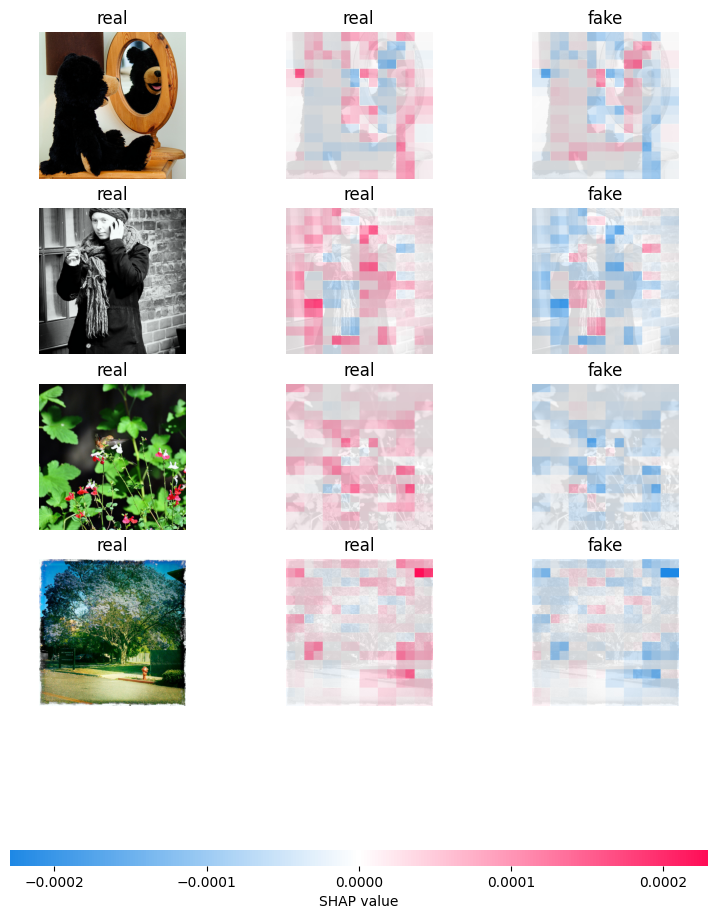

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|██████████████████████                                                                  | 1/4 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|████████████████████████████████████████████████████████████                    | 3/4 [04:07<01:01, 61.86s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [06:10<00:00, 87.45s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [08:13, 123.39s/it]                                                                                            


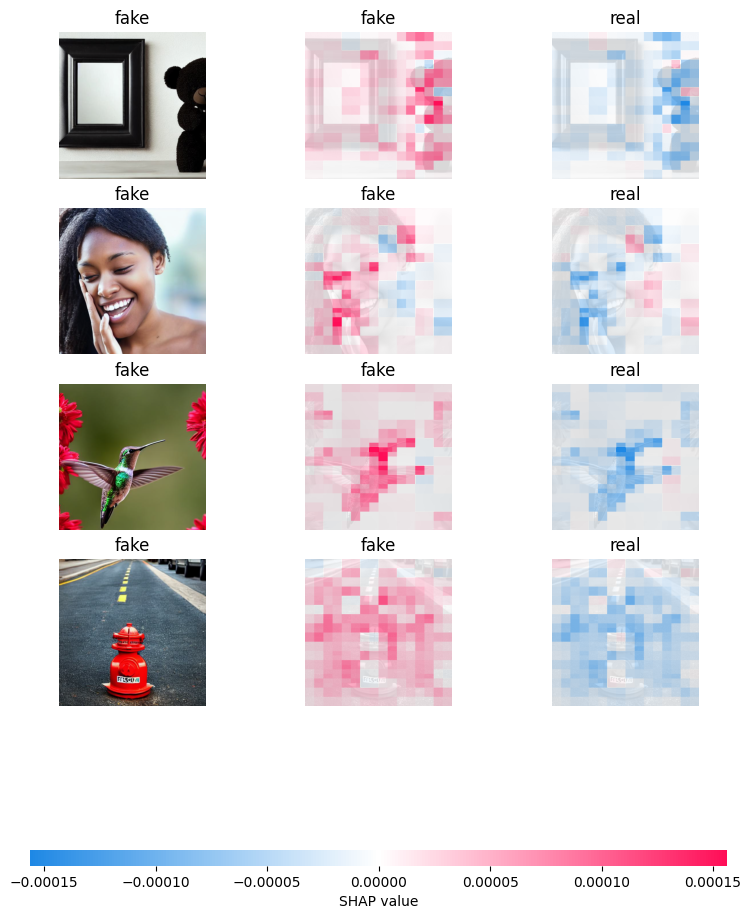

In [12]:
batch = next(it)
real = batch["real"].to(DEVICE)
explain(explainer, real, ["real"] * real.shape[0])

fake = batch["fake"][0].to(DEVICE)
explain(explainer, fake, ["fake"] * fake.shape[0])

In [ ]:
batch = next(it)
real = batch["real"].to(DEVICE)
explain(explainer, real, ["real"] * real.shape[0])

fake = batch["fake"][0].to(DEVICE)
explain(explainer, fake, ["fake"] * fake.shape[0])

In [ ]:
batch = next(it)
real = batch["real"].to(DEVICE)
explain(explainer, real, ["real"] * real.shape[0])

fake = batch["fake"][0].to(DEVICE)
explain(explainer, fake, ["fake"] * fake.shape[0])

In [ ]:
raise Exception("STOP")

In [ ]:
data = shap_values.data.cpu().numpy()
data = np.array(
    [normalize_image(torch.tensor(x)).cpu().numpy() for x in data]
)
values = ([val for val in np.moveaxis(shap_values.values, -1, 0)])

shap.image_plot(
    shap_values=values,
    pixel_values=data,
#     labels=shap_values.output_names,
    labels=np.array([["Real", "Fake"],["Real", "Fake"],["Real", "Fake"],["Real", "Fake"]]),
    true_labels=["Real", "Real", "Real", "Real"],
)